
# Relationship-based Character Selection
---

In this module, we aim to select characters based on the available relation information. By doing so, the story generator can integrate more contextual knowledge about the universe and make the story more coherent. 


In [ ]:
main_characters = {"Jon_Snow": "Q3183235",
                   "Daenerys_Targaryen": "Q2708078",
                   "Arya_Stark": "Q3624677",
                   "Bran_Stark": "Q3643599",
                   "Cersei_Lannister": "Q3665163", 
                   "Tyrion_Lannister" : "Q2076759",
                   "Margaery_Tyrell": "Q12900933",
                   "Petyr_Baelish": "Q4360302",
                   "Robert_Baratheon" : "Q13634885"}



---


## Using the "Network of Thrones" data

The Network of Thrones data uses the Game of Thrones scripts to create a weighted relationship graph. The interaction types between Character A and Character B are defined as following:

1. Character A speaks directly after Character B
2. Character A speaks about Character B
3. Character C speaks about Character A and Character B
4. Character A and Character B are mentioned in the same stage direction
5. Character A and Character B appear in a scene together

The weight of the edge between two characters is determined by the number of times they interact in the script.


In [ ]:
!git clone https://github.com/mathbeveridge/gameofthrones

Cloning into 'gameofthrones'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 62 (delta 0), reused 2 (delta 0), pack-reused 55
Unpacking objects: 100% (62/62), done.


In [ ]:
import os
import pandas as pd
import random

f = "gameofthrones/data/"
edges = []
nodes = []

for d in sorted(os.listdir(f)):
  if "edge" in d:
    edges.append(pd.read_csv(f+d))
  elif "node" in d:
    nodes.append(pd.read_csv(f+d))

FileNotFoundError: ignored

In [ ]:
## Given a character and desired season, return a character selected 
## randomly from the top N relations with respect to their weights.

def find_related_character(season, character_id, n):
  so = edges[season-1][edges[season-1].Source == character_id][["Target", "Weight"]].rename({'Target': 'Relation'}, axis=1)
  ta = edges[season-1][edges[season-1].Target == character_id][["Source", "Weight"]].rename({'Source': 'Relation'}, axis=1)

  relations = so.append(ta).sort_values(by = "Weight", ascending=False)[:n]
  related_character = random.choices(list(relations["Relation"]), weights=list(relations["Weight"]))
  return related_character

find_related_character(1, "CERSEI", 1)

['NED']

In [ ]:
nodes

,Id,Label
0,Addam_Marbrand,Addam Marbrand
1,Aegon_Frey_(son_of_Stevron),Aegon Frey (son of Stevron)
2,Aegon_I_Targaryen,Aegon I Targaryen
3,Aegon_Targaryen_(son_of_Rhaegar),Aegon Targaryen (son of Rhaegar)
4,Aegon_V_Targaryen,Aegon V Targaryen
...,...,...
791,Yorko_Terys,Yorko Terys
792,Ysilla,Ysilla
793,Yurkhaz_zo_Yunzak,Yurkhaz zo Yunzak
794,Zei,Zei


In [ ]:
edges = pd.read_csv("asoiaf-all-edges.csv")
edges_subset = []
for line in edges.iterrows():
  for char in main_characters:
    if(line[1]['Source'] == char or line[1]['Target'] == char):
      edges_subset.append(line[1])

nodes = pd.read_csv("asoiaf-all-nodes.csv")
nodes_subset = []
for line in nodes.iterrows():
  for char in main_characters:
    if(line[1]['Id'] == char):
      nodes_subset.append(line[1])

pd.DataFrame(edges_subset).to_csv("edges_subset.csv", index = False)
pd.DataFrame(nodes_subset).to_csv("nodes_subset.csv", index = False)

In [ ]:
edges

,Source,Target,Type,id,weight
0,Addam_Marbrand,Cersei_Lannister,Undirected,1,3
1,Addam_Marbrand,Tyrion_Lannister,Undirected,9,7
2,Aegon_I_Targaryen,Daenerys_Targaryen,Undirected,16,13
3,Aegon_I_Targaryen,Tyrion_Lannister,Undirected,23,3
4,Aegon_Targaryen_(son_of_Rhaegar),Daenerys_Targaryen,Undirected,25,11
...,...,...,...,...,...
681,Tyrion_Lannister,Willis_Wode,Undirected,2805,4
682,Tyrion_Lannister,Yandry,Undirected,2806,15
683,Tyrion_Lannister,Yezzan_zo_Qaggaz,Undirected,2807,17
684,Tyrion_Lannister,Yoren,Undirected,2808,10


In [ ]:
def read_network_data():
    edges = pd.read_csv("edges_subset.csv")
    nodes = pd.read_csv("nodes_subset.csv")
    return nodes, edges

def relation_based_pick(ist_class, related_to_char, n):
    so = edges[edges.Source == related_to_char][["Target", "weight"]].rename({'Target': 'Relation'}, axis=1)
    ta = edges[edges.Target == related_to_char][["Source", "weight"]].rename({'Source': 'Relation'}, axis=1)

    relations = so.append(ta).sort_values(by="weight", ascending=False)[:n]
    related_character = random.choices(list(relations["Relation"]), weights=list(relations["weight"]))
    return related_character

nodes, edges = read_network_data()
relation_based_pick("text", 'Cersei_Lannister', 1)

['Tyrion_Lannister']

In [ ]:
relations

,Relation,weight
304,Tyrion_Lannister,209
303,Tyrion_Lannister,209
250,Joffrey_Baratheon,173
289,Robert_Baratheon,134
290,Robert_Baratheon,134


Even though this approach represents the dynamics of the series, it does not provide information on the nature of the relation. For example, Ned Stark is the top candidate to be Cersei Lannister's "mentor", even though they are enemies. Therefore, we need a different approach to identify positive/negative relations.



---

## Using Game of Thrones Fandom Wiki

Fandom Wiki contains more detailed information about the dynamics of the series, with information such as family relations and love interests. Using the info bar, we can scrape such information to generate a graph. However, the information stored there is unstructured and inconsistent, and requires a lot of manual processing. 

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
wikiurl="https://gameofthrones.fandom.com/wiki/Jon_Snow"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)

soup = BeautifulSoup(response.text, 'html.parser')
table_text =soup.find('aside',{'class':"portable-infobox"}).text
print(table_text)


Jon Snow






Biographical information

Status
Alive


Born
Aegon Targaryen280 AC (age 25) at the Tower of Joy


Died
302 AC at Castle BlackStabbed to death by his own men in a mutiny (later resurrected)



Political information

Allegiance
House Targaryen (by birth)House Stark (raised)Night's Watch


Title(s)
998th Lord Commander of the Night's Watch (formerly)King in the North (formerly)Warden of the North (formerly)


Predecessor(s)
{Jeor Mormont} (Lord Commander){Robb Stark} (King in the North){Ramsay Bolton} (Warden of the North)


Successor(s)
{Eddison Tollett} (acting Lord Commander)Sansa Stark (Queen in the North)



Personal information

Also known as
Lord SnowThe Bastard of WinterfellKing CrowThe Prince That Was PromisedThe White Wolf


Culture
Northman


Religion
Old Gods of the Forest


Father
{Rhaegar Targaryen} (biological){Eddard Stark} (adoptive)


Mother
{Lyanna Stark}


Lover(s)
{Ygritte}{Daenerys I Targaryen}


Sibling(s)
Paternal half-siblings:{Rhaenys Targaryen}{

In [ ]:
import re

important_info = ["Allegiance","Title","Predecessor","Successor","Also known as", "Culture", "Religion", "Father","Mother", "Lover", "Spouse","Child(ren)","Sibling"]

info_title = ""
character_info = {}
for line in table_text.split("\n\n\n"):
  #print(repr(line))
  line = line.replace(')', ')\t')
  line = line.replace('}', '\t').replace('{', '')
  for point in line.split("\n"):
    #print(repr(point.strip("\t")))
    if info_title:
      ###detail = re.findall(r'\([^)]*\)', str(point))
      point = re.sub(r'\([^)]*\)', '', point)
      info = list(filter(None, point.split("\t")))
      
      if len(info) == 1:
        character_info[info_title] = info[0]
      else:
        info = [(i.strip() if i != " " else "") for i in info]
        info = list(filter(None, info))
        character_info[info_title] = info
      info_title = ""

    if point.strip("\t").strip("(s)") in important_info:
      info_title = point.strip("\t").strip("(s)")

character_info

{'Allegiance': ['House Targaryen', 'House Stark', "Night's Watch"],
 'Culture': 'Northman',
 'Father': ['Rhaegar Targaryen', 'Eddard Stark'],
 'Lover': ['Ygritte', 'Daenerys I Targaryen'],
 'Mother': 'Lyanna Stark',
 'Predecessor': ['Jeor Mormont', 'Robb Stark', 'Ramsay Bolton'],
 'Religion': 'Old Gods of the Forest',
 'Sibling': ['Paternal half-siblings:Rhaenys Targaryen',
  'Aegon Targaryen',
  'Maternal cousins raised as half-siblings:Robb Stark',
  'Sansa StarkArya StarkBran I the BrokenRickon Stark'],
 'Successor': ['Eddison Tollett', 'Sansa Stark'],
 'Title': ["998th Lord Commander of the Night's Watch",
  'King in the North',
  'Warden of the North']}

In [ ]:
def get_wiki_page(character_id, character_label):
  wikiurl="https://gameofthrones.fandom.com/wiki/"+character_id
  table_class="wikitable sortable jquery-tablesorter"
  response=requests.get(wikiurl)
  #print(response)
  soup = BeautifulSoup(response.text, 'html.parser')
  try:
    table_text =soup.find('aside',{'class':"portable-infobox"}).text
    #print(repr(table_text))

  except:
    wikiurl="https://gameofthrones.fandom.com/wiki/"+character_label.replace(" ", "_")
    table_class="wikitable sortable jquery-tablesorter"
    response=requests.get(wikiurl)
    #print(response)
    soup = BeautifulSoup(response.text, 'html.parser')
    try:
      table_text =soup.find('aside',{'class':"portable-infobox"}).text
    except:
      print(character_id)

## Using Wikidata information on Game of Thrones characters

Wikidata provides well-structured information about the characters. However, information is more surface-level (e.g. family or formal partners) and does not contain certain details (e.g. enemies or allies).

We manually investigate the interesting properties to include, and note their IDs to use for querying. We also create a list of main characters and their IDs for more detailed extraction, whereas side characters that are related to main characters will not contain any additional info.

In [ ]:
!pip install wikidata

from wikidata.client import Client
client = Client()  # doctest: +SKIP
entity = client.get('Q3183235', load=True)
entity


<wikidata.entity.Entity Q3183235 'Jon Snow'>

### Promising part

In [ ]:
from string import Template

query_template = Template("""SELECT ?o ?oLabel WHERE {wd:$char wdt:$p ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}""")

query_template_q = Template("""SELECT ?o ?oLabel ?q ?qLabel WHERE {wd:$char p:$p [ps:$p ?o; pq:$pq ?q; ]. SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}""")
 
# Substitute value of x in above template
char_id = 'Q2708078'
p = 'P3373'
pq = 'P1039'

print(query_template.substitute({'char': char_id, 'p': p}))
print(query_template_q.substitute({'char': char_id, 'p': p, 'pq':pq}))

SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P3373 ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}
SELECT ?o ?oLabel ?q ?qLabel WHERE {wd:Q2708078 p:P3373 [ps:P3373 ?o; pq:P1039 ?q; ]. SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}


In [ ]:
!pip install SPARQLWrapper
import sys
import re
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


     |████████████████████████████████| 482 kB 10.7 MB/s 
     |████████████████████████████████| 41 kB 729 kB/s 


In [ ]:
info_lst =  {'father' : {'p': 'P22', 'range':'Character'},
             'mother' : {'p' : 'P25', 'range':'Character'},
             'sibling' : {'p' : 'P3373', 'range':'Character'} ,
             'child' : {'p' : 'P40', 'range':'Character'} ,
             'partner' : {'p': 'P451', 'range':'Character'},
             'spouse' : {'p' : 'P26', 'range':'Character'} ,
             'relative': {'p': 'P1038', 'range':'Character'},
##             'relative': {'p': 'P1038', 'pq': 'P1039'},
             'family' : {'p': 'P53', 'range':'House'},
             'occupation': {'p':'P106', 'range':'Occupation'},
             'title' : {'p' : 'P97', 'range': 'Title'},
             'place_of_death' : {'p': 'P20', 'range':'Place'},
             'cause_of_death': {'p': 'P509', 'range':'Cause_of_death'},
             'battles_participated' : {'p': 'P607', 'range':'Battle'}}

main_characters = {"Jon_Snow": "Q3183235",
                   "Daenerys_Targaryen": "Q2708078",
                   "Arya_Stark": "Q3624677",
                   "Bran_Stark": "Q3643599",
                   "Cersei_Lannister": "Q3665163", 
                   "Tyrion_Lannister" : "Q2076759",
                   "Margaery_Tyrell": "Q12900933",
                   "Petyr_Baelish": "Q4360302",
                   "Robert_Baratheon" : "Q13634885"}


def generate_query(char_id):
  char_query = {}
  for label in info_lst.keys():
    query_dict = {'char':char_id, 'p': info_lst[label]['p']}
    try:
      query_dict['pq'] = info_lst[label]['pq']
      char_query[label] = query_template_q.substitute(query_dict)
    except:
      char_query[label] = query_template.substitute(query_dict)

  return char_query


def query_wikidata(char_query):
  results = {}
  for label in char_query.keys():
    if "pq" in char_query[label]:
      results[label] = [[result['oLabel']['value'], result['qLabel']['value']] for result in get_results(endpoint_url, char_query[label])['results']['bindings']]
    else:
      results[label] = [result['oLabel']['value'] for result in get_results(endpoint_url, char_query[label])['results']['bindings']]
    
  return results

In [ ]:
print(generate_query("Q2708078"))
print(query_wikidata(generate_query("Q2708078")))

{'father': 'SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P22 ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}', 'mother': 'SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P25 ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}', 'sibling': 'SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P3373 ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}', 'child': 'SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P40 ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}', 'partner': 'SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P451 ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}', 'spouse': 'SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P26 ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}', 'relative': 'SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P1038 ?o . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }}', 'family': 'SELECT ?o ?oLabel WHERE {wd:Q2708078 wdt:P53 ?o . SERVICE wikib

In [ ]:
def generate_side_character_rdf(prop, line):
  if not line in main_characters: 
    return "HERO:"+line+" a HERO:"+info_lst[prop]['range']+" .\n"

def generate_main_char_rdf(character, output, general_instances):
  rdf = ":"+character.replace(" ", "_") + " a HERO:Main_Character;\n"
  for prop in output.keys():
    for line in output[prop]:
      if len(output[prop][0])==2:
        rdf += "\tHERO:"+prop+" HERO:"+line[0].replace(" ", "_") +" ;\n"
        rdf += "\tHERO:"+line[1].replace(" ", "_")+" HERO:"+line[0].replace(" ", "_") +" ;\n"
        general_instances.add(line[0].replace(" ", "_"))
      else:
        rdf += "\tHERO:"+prop+" HERO:"+line.replace(" ", "_") +" ;\n"
        general_instances.add(generate_side_character_rdf(prop, line.replace(" ", "_")))
  rdf += "."
  
  return rdf

general_instances = set()
print(generate_main_char_rdf("Jon_Snow", query_wikidata(generate_query("Q2708078")), general_instances))
general_instances

:Jon_Snow a HERO:Main_Character;
	HERO:father HERO:Aerys_II_Targaryen ;
	HERO:mother HERO:Rhaella_Targaryen ;
	HERO:sibling HERO:Viserys_Targaryen ;
	HERO:sibling HERO:Rhaegar_Targaryen ;
	HERO:partner HERO:Jon_Snow ;
	HERO:partner HERO:Daario_Naharis ;
	HERO:spouse HERO:Khal_Drogo ;
	HERO:spouse HERO:Hizdahr_zo_Loraq ;
	HERO:family HERO:House_Targaryen ;
	HERO:occupation HERO:ruler ;
	HERO:occupation HERO:revolutionary ;
	HERO:title HERO:fictional_princess ;
.


{'HERO:Aerys_II_Targaryen a HERO:Character .\n',
 'HERO:Daario_Naharis a HERO:Character .\n',
 'HERO:Hizdahr_zo_Loraq a HERO:Character .\n',
 'HERO:House_Targaryen a HERO:House .\n',
 'HERO:Khal_Drogo a HERO:Character .\n',
 'HERO:Rhaegar_Targaryen a HERO:Character .\n',
 'HERO:Rhaella_Targaryen a HERO:Character .\n',
 'HERO:Viserys_Targaryen a HERO:Character .\n',
 'HERO:fictional_princess a HERO:Title .\n',
 'HERO:revolutionary a HERO:Occupation .\n',
 'HERO:ruler a HERO:Occupation .\n',
 None}

In [ ]:
def just_please_work(main_characters):
  rdf = """ @base <http://hero_ontology/> .
            @prefix HERO: <http://hero_ontology/> .
            @prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
            @prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
            @prefix owl: <http://www.w3.org/2002/07/owl#> .
            @prefix sem: <http://semanticweb.cs.vu.nl/2009/11/sem/> .
        """

  general = set()
  for character in main_characters.keys():
    print(character)
    char_id = main_characters[character]
    output = query_wikidata(generate_query(char_id))
    rdf += "#### " + character + " ####\n" + generate_main_char_rdf(character, output, general) + "\n\n"

  print("Main characters added.")

  for line in general:
    if line:
     rdf += line

  return re.sub(r"[()\'\,]", "", rdf)

instance_rdf = just_please_work(main_characters)
text_file = open("got_instances.ttl", "w")
text_file.write(instance_rdf)
text_file.close()

print(instance_rdf)

Jon_Snow
Daenerys_Targaryen
Arya_Stark
Bran_Stark
Cersei_Lannister
Tyrion_Lannister
Margaery_Tyrell
Petyr_Baelish
Robert_Baratheon
Main characters added.
 @base <http://hero_ontology/> .
            @prefix HERO: <http://hero_ontology/> .
            @prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
            @prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
            @prefix owl: <http://www.w3.org/2002/07/owl#> .
            @prefix sem: <http://semanticweb.cs.vu.nl/2009/11/sem/> .
        #### Jon_Snow ####
:Jon_Snow a HERO:Main_Character;
	HERO:father HERO:Rhaegar_Targaryen ;
	HERO:mother HERO:Lyanna_Stark ;
	HERO:sibling HERO:Rhaenys_Targaryen_daughter_of_Rhaegar ;
	HERO:sibling HERO:Aegon_Targaryen ;
	HERO:partner HERO:Daenerys_Targaryen ;
	HERO:partner HERO:Ygritte ;
	HERO:relative HERO:Eddard_Stark ;
	HERO:relative HERO:Daenerys_Targaryen ;
	HERO:relative HERO:Viserys_Targaryen ;
	HERO:relative HERO:Aerys_II_Targaryen ;
	HERO:relative HERO:Rhaella_Targaryen

### Analyzing the relations

In [ ]:
!pip install rdflib

from rdflib import Graph, ConjunctiveGraph, Literal, BNode, Namespace, RDF, URIRef, RDFS
from rdflib.namespace import DC, FOAF

import pprint

In [ ]:
got = Graph()
got_instance = Graph()

results = got.parse("got_prop_class.ttl") + got_instance.parse("got_instances.ttl")
print(results.serialize(format = "nt"))

FileNotFoundError: ignored

### Community Detection with Networkx

Using SPARQL, we query the generated RDF network and extract the total number of relations between each character, using the query below. Then using the output (downloaded as .csv), we create a NetworkX graph with weights. 

The NetworkX package provides methods for community detection. Using these we can identify the communities within our graph and return related characters from within a community. The visualization of the communities are also below.

In [ ]:
# The SPARQL query below returns the number of edges between two characters.
# The output is used to generate a weighted NetworkX graph, and to detect communities.

# The query is run on GraphDB and the output downloaded as .csv is used here.

"""
PREFIX : <http://visualdataweb.org/GoT/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT ?char1 ?char2 (COUNT(?char1) as ?valueSum)
WHERE
{
  ?char1 ?p ?char2 .
  ?char1 a :Character .
  ?char2 a :Character .
}
GROUP BY ?char1 ?char2
"""

'\nPREFIX : <http://visualdataweb.org/GoT/>\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nSELECT ?char1 ?char2 (COUNT(?char1) as ?valueSum)\nWHERE\n{\n  ?char1 ?p ?char2 .\n  ?char1 a :Character .\n  ?char2 a :Character .\n}\nGROUP BY ?char1 ?char2\n'

In [ ]:
import pandas as pd

df = pd.read_csv("query-result.csv", sep = ",")
df['char1'] = [i[-1] for i in df['char1'].str.split("/")]
df['char2'] = [i[-1] for i in df['char2'].str.split("/")]
df

,char1,char2,valueSum
0,Jon_Snow,Rhaegar_Targaryen,1
1,Jon_Snow,Lyanna_Stark,1
2,Jon_Snow,Rhaenys_Targaryen_daughter_of_Rhaegar,1
3,Jon_Snow,Aegon_Targaryen,1
4,Jon_Snow,Daenerys_Targaryen,2
...,...,...,...
59,Margaery_Tyrell,Willas_Tyrell,1
60,Margaery_Tyrell,Garlan_Tyrell,1
61,Margaery_Tyrell,Joffrey_Baratheon,1
62,Margaery_Tyrell,Tommen_Baratheon,1


In [ ]:
import networkx as nx

tuples_lst = [(x[1]['char1'], x[1]['char2'],x[1]['valueSum']) for x in df.iterrows()]

G = nx.Graph()
G.add_weighted_edges_from(tuples_lst)
G

In [ ]:
import networkx as nx

tuples_lst = [(x[1]['char1'].split("_")[0], x[1]['char2'].split("_")[0], {'weight': x[1]['valueSum']}) for x in df.iterrows()]

G = nx.Graph(tuples_lst)
#G.add_weighted_edges_from()
G

{('Arya', 'Bran'): Text(0.42309577864649606, 0.012972062420625267, '1'),
 ('Arya', 'Catelyn'): Text(0.4952498014516012, 0.0257693699761425, '1'),
 ('Arya', 'Rickon'): Text(0.48421617290735747, 0.062483906794596214, '1'),
 ('Arya', 'Robb'): Text(0.44854234967675155, 0.06732337950929589, '1'),
 ('Arya', 'Sansa'): Text(0.3425721875163339, 0.09650554155750708, '1'),
 ('Bran', 'Rickon'): Text(0.4678861505584393, 0.06662360238989032, '1'),
 ('Bran', 'Robb'): Text(0.4322123273278333, 0.07146307510458999, '1'),
 ('Catelyn', 'Bran'): Text(0.478919779102683, 0.0299090655714366, '1'),
 ('Cersei', 'Euron'): Text(-0.27356947789161634, 0.36350773503789546, '1'),
 ('Cersei', 'Jaime'): Text(-0.23411221990222855, 0.43035086803528705, '2'),
 ('Cersei', 'Joanna'): Text(-0.20750319786576285, 0.47741698390327436, '1'),
 ('Cersei', 'Joffrey'): Text(-0.42135920312034786, 0.4280834513310884, '1'),
 ('Cersei', 'Lancel'): Text(-0.29529290444798245, 0.3379928557032712, '1'),
 ('Cersei', 'Myrcella'): Text(-0.2505

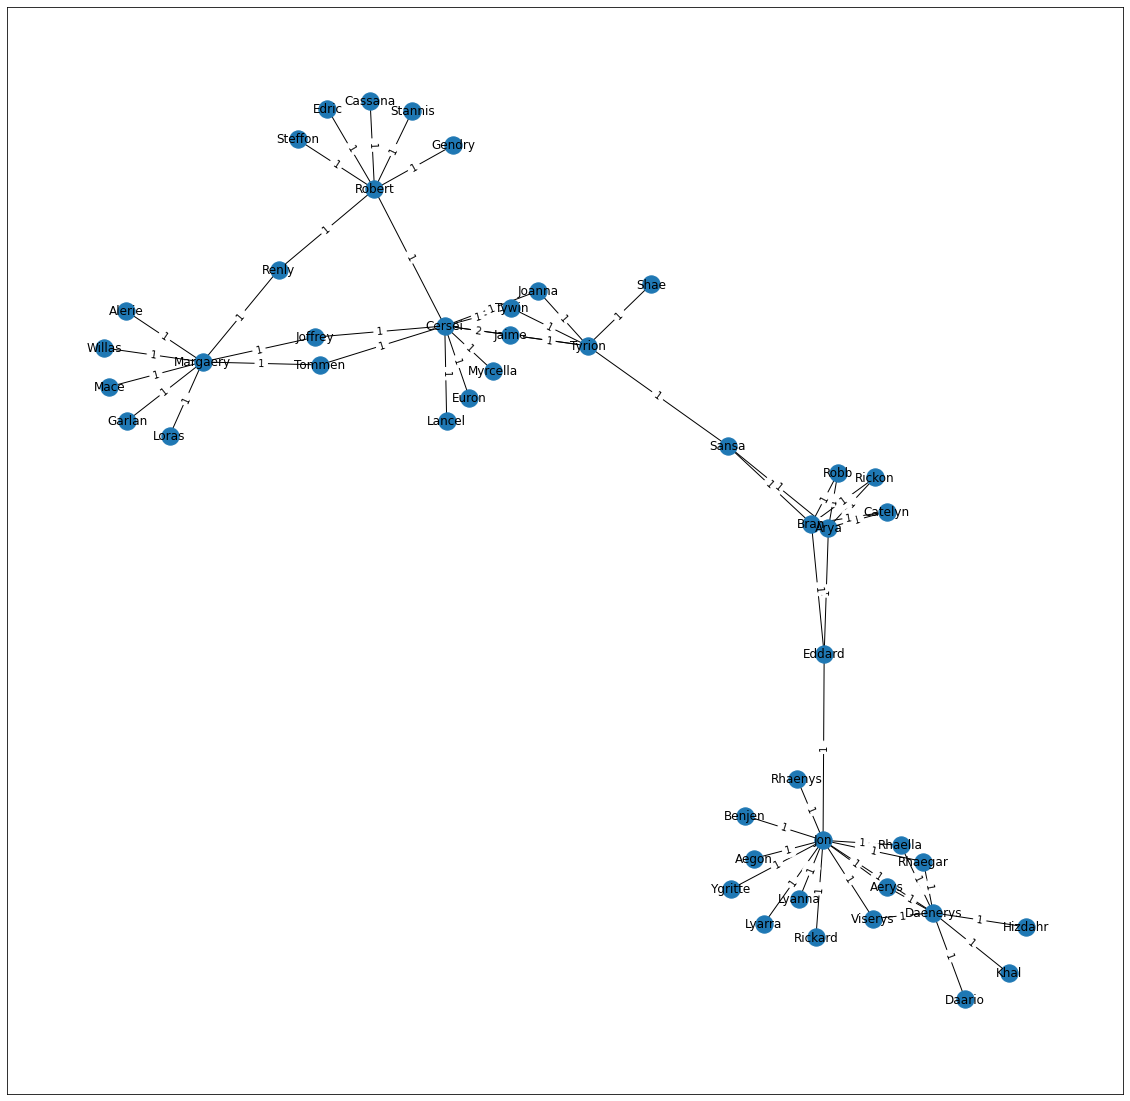

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,20)


pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [ ]:
import networkx.algorithms.community as nxcom

communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(communities)

[frozenset({'Aerys', 'Hizdahr', 'Daario', 'Benjen', 'Rickard', 'Lyarra', 'Rhaella', 'Ygritte', 'Daenerys', 'Rhaenys', 'Viserys', 'Khal', 'Aegon', 'Rhaegar', 'Jon', 'Lyanna'}), frozenset({'Lancel', 'Joanna', 'Shae', 'Tyrion', 'Euron', 'Cersei', 'Tywin', 'Myrcella', 'Jaime'}), frozenset({'Loras', 'Alerie', 'Mace', 'Joffrey', 'Garlan', 'Margaery', 'Willas', 'Tommen'}), frozenset({'Sansa', 'Catelyn', 'Rickon', 'Bran', 'Arya', 'Eddard', 'Robb'}), frozenset({'Renly', 'Robert', 'Cassana', 'Gendry', 'Steffon', 'Stannis', 'Edric'})]


In [ ]:
communities_dict = {}
for com in communities:
  for mc in main_characters.keys():
    if mc in list(com):
      com_copy = list(com)
      com_copy.remove(mc)
      communities_dict[mc] = com_copy

communities_dict['Arya_Stark']

KeyError: ignored

In [ ]:
import random 
def find_communities(weighted_input):
  df = pd.read_csv(weighted_input, sep = ",")
  df['char1'] = [i[-1] for i in df['char1'].str.split("/")]
  df['char2'] = [i[-1] for i in df['char2'].str.split("/")]

  tuples_lst = [(x[1]['char1'], x[1]['char2'],x[1]['valueSum']) for x in df.iterrows()]
  G = nx.Graph()
  G.add_weighted_edges_from(tuples_lst)

  communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)

  communities_dict = {}
  for com in communities:
    for mc in main_characters.keys():
      if mc in list(com):
        com_copy = list(com)
        com_copy.remove(mc)
        communities_dict[mc] = com_copy

  return communities_dict

communities = find_communities("query-result.csv")
def hero_pick():
  return random.choice(list(communities.keys()))

hero_pick()

def comm_based_pick(ist_class, hero):
  category = ist_class.split("/")[-1]
  if category == "Actor":
    return random.choice(list(communities[hero]))
  return random_pick(ist_class) 

comm_based_pick("http://semanticweb.cs.vu.nl/2009/11/sem/Actor", "Jon_Snow")


# {'jon_snow: ["bsd","njd","aknd","daenerys_targ"]}

'Rhaenys_Targaryen_daughter_of_Rhaegar'

In [ ]:
[{k: communities[k]} for k in communities.keys() if (not "Jon_Snow" in communities[k] and k != "Jon_Snow")]

[{'Cersei_Lannister': ['Jaime_Lannister',
   'Tyrion_Lannister',
   'Lancel_Lannister',
   'Shae',
   'Myrcella_Baratheon',
   'Joanna_Lannister',
   'Euron_Greyjoy',
   'Tywin_Lannister']},
 {'Tyrion_Lannister': ['Jaime_Lannister',
   'Cersei_Lannister',
   'Lancel_Lannister',
   'Shae',
   'Myrcella_Baratheon',
   'Joanna_Lannister',
   'Euron_Greyjoy',
   'Tywin_Lannister']},
 {'Margaery_Tyrell': ['Willas_Tyrell',
   'Joffrey_Baratheon',
   'Garlan_Tyrell',
   'Alerie_Tyrell',
   'Loras_Tyrell',
   'Tommen_Baratheon',
   'Mace_Tyrell']},
 {'Arya_Stark': ['Bran_Stark',
   'Catelyn_Stark',
   'Sansa_Stark',
   'Eddard_Stark',
   'Robb_Stark',
   'Rickon_Stark']},
 {'Bran_Stark': ['Catelyn_Stark',
   'Sansa_Stark',
   'Eddard_Stark',
   'Robb_Stark',
   'Rickon_Stark',
   'Arya_Stark']},
 {'Robert_Baratheon': ['Stannis_Baratheon',
   'Steffon_Baratheon',
   'Cassana_Baratheon',
   'Renly_Baratheon',
   'Gendry',
   'Edric_Storm']}]

In [ ]:
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The graph has {len(communities)} communities.")

The graph has 5 communities.


In [ ]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
            
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)


set_node_community(G, communities)
set_edge_community(G)
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

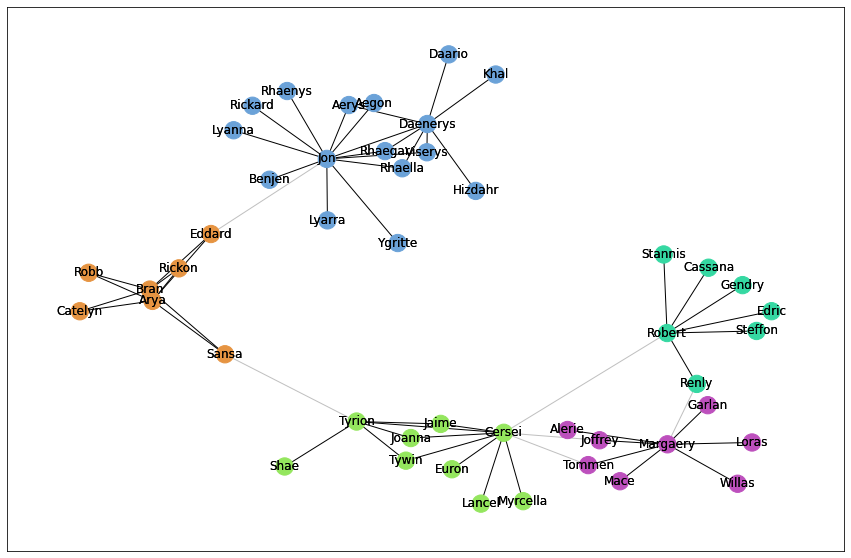

In [ ]:
import math
G_pos = nx.spring_layout(G, k=2/math.sqrt(G.order()))
plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    G,
    pos=G_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")

# Draw nodes and internal edges
nx.draw_networkx(
    G,
    pos=G_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)

In [ ]:
len(list(communities[0]))

18